In [1]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
from processing_functions import create_df
import matplotlib.pyplot as plt 

df_main = create_df(timeFramesUsedInMinutes=["5"], instrument="ES", 
                    start_date = "2023-03-24 12:00", end_date = "2025-02-14 12:00") #chopPeriod=14)

In [ ]:
from processing_functions import create_not_processed_df
import pandas as pd
from tqdm import tqdm
import numpy as np
# Appliquer la fonction sur chaque bougie 5min
df_5min = create_not_processed_df(timeFramesUsedInMinutes=["5"], instrument="ES")
df_1min = create_not_processed_df(timeFramesUsedInMinutes=["1"], instrument="ES")
print(df_5min.shape)
print(df_1min.shape)
high_before_low_results = []

def high_before_low(df_1min_segment):

    # Identifier l'index du maximum high et du minimum low
    high_index = df_1min_segment['high'].idxmax()
    low_index = df_1min_segment['low'].idxmin()
    
    return high_index < low_index
 
for timestamp in tqdm(df_5min["datetime"], desc="Processing 5-min intervals", unit="interval"):
    # Définir la fenêtre de 5 minutes
    start_time = timestamp
    end_time = timestamp + pd.Timedelta(minutes=5)
    df_segment = df_1min[(df_1min['datetime'] >= start_time) & (df_1min['datetime'] < end_time)]
    if len(df_segment)==0: 
        high_before_low_results.append(np.nan)
    else:
        high_before_low_results.append(high_before_low(df_segment))

# Ajouter la colonne "high_before_low" au DataFrame 5 minutes
df_5min['high_before_low'] = high_before_low_results
print(df_5min[['datetime', 'high_before_low']])


(354751, 6)
(1744781, 6)


Processing 5-min intervals:   2%|▏         | 7662/354751 [01:30<1:08:26, 84.53interval/s]


KeyboardInterrupt: 

In [ ]:
csv_name = "test_MES_5min"
df_5min.to_csv("C:/Users/tessa/MotiveWave Data/"+csv_name, index=False)


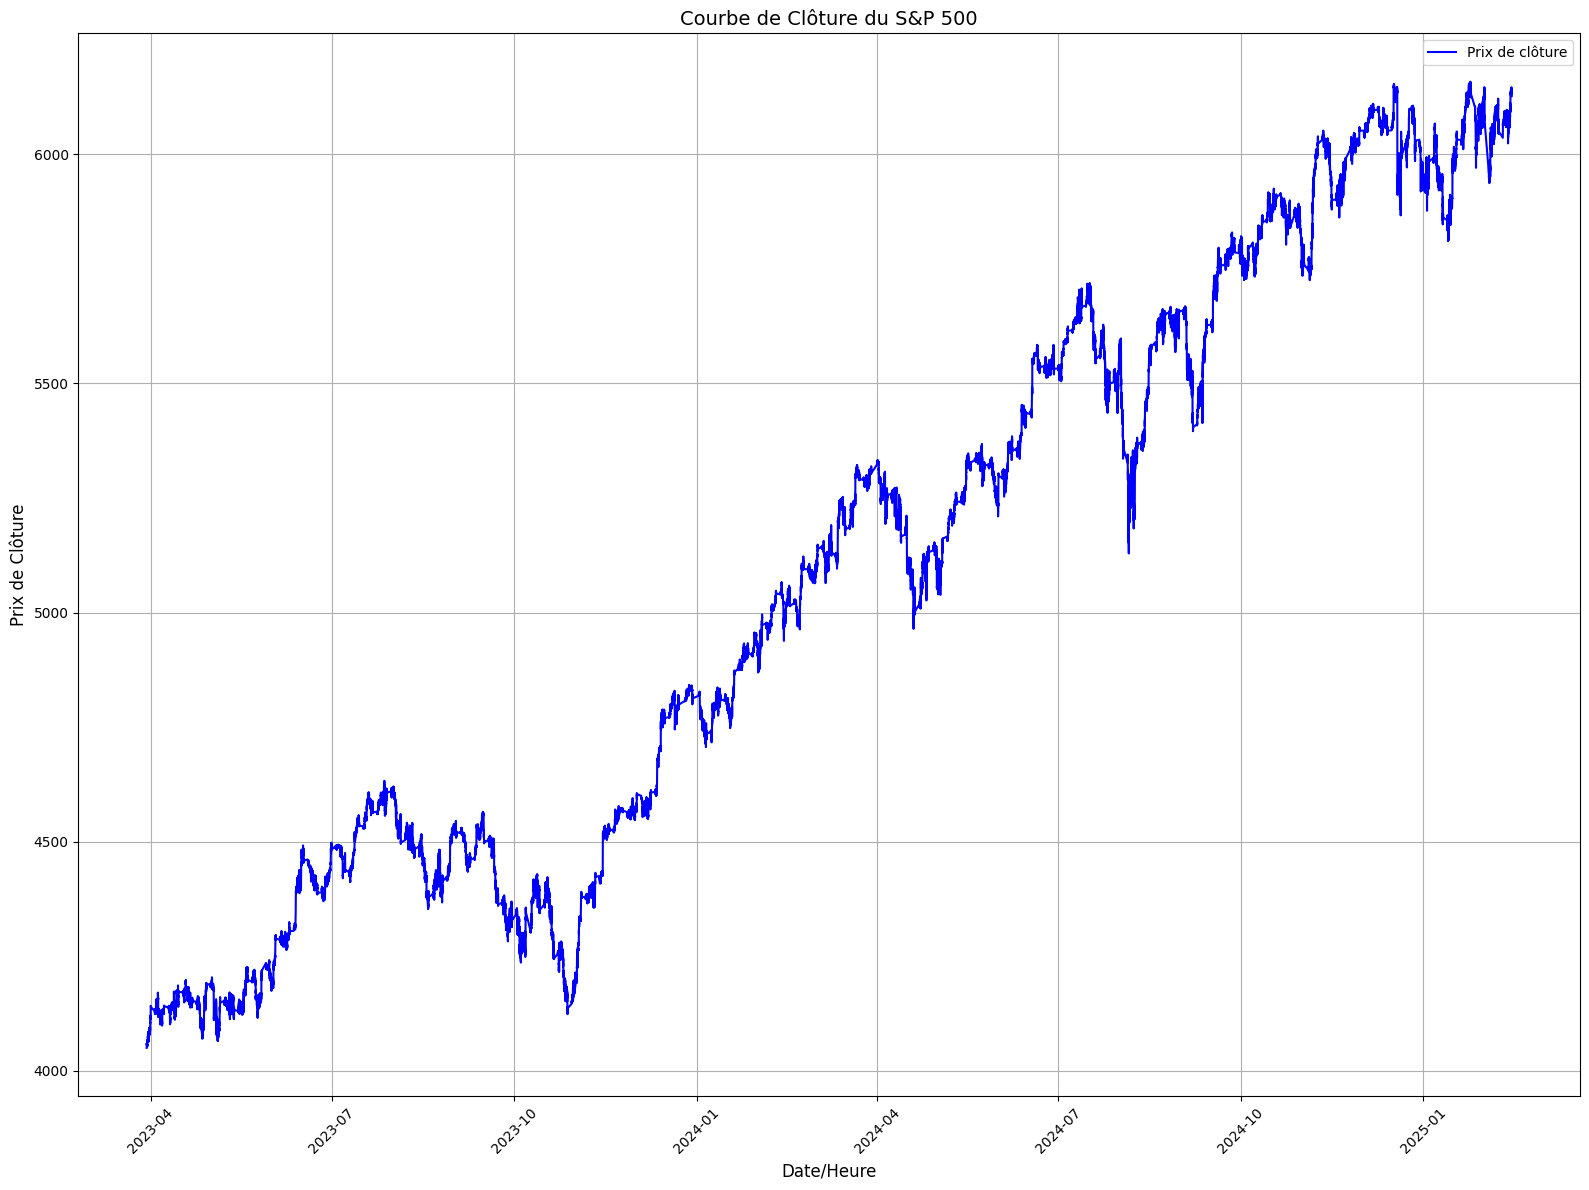

In [3]:
plt.figure(figsize=(16,12))
plt.plot(df_main['datetime'], df_main['close'], label='Prix de clôture', color='b')
plt.title('Courbe de Clôture du S&P 500', fontsize=14)
plt.xlabel('Date/Heure', fontsize=12)
plt.ylabel('Prix de Clôture', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

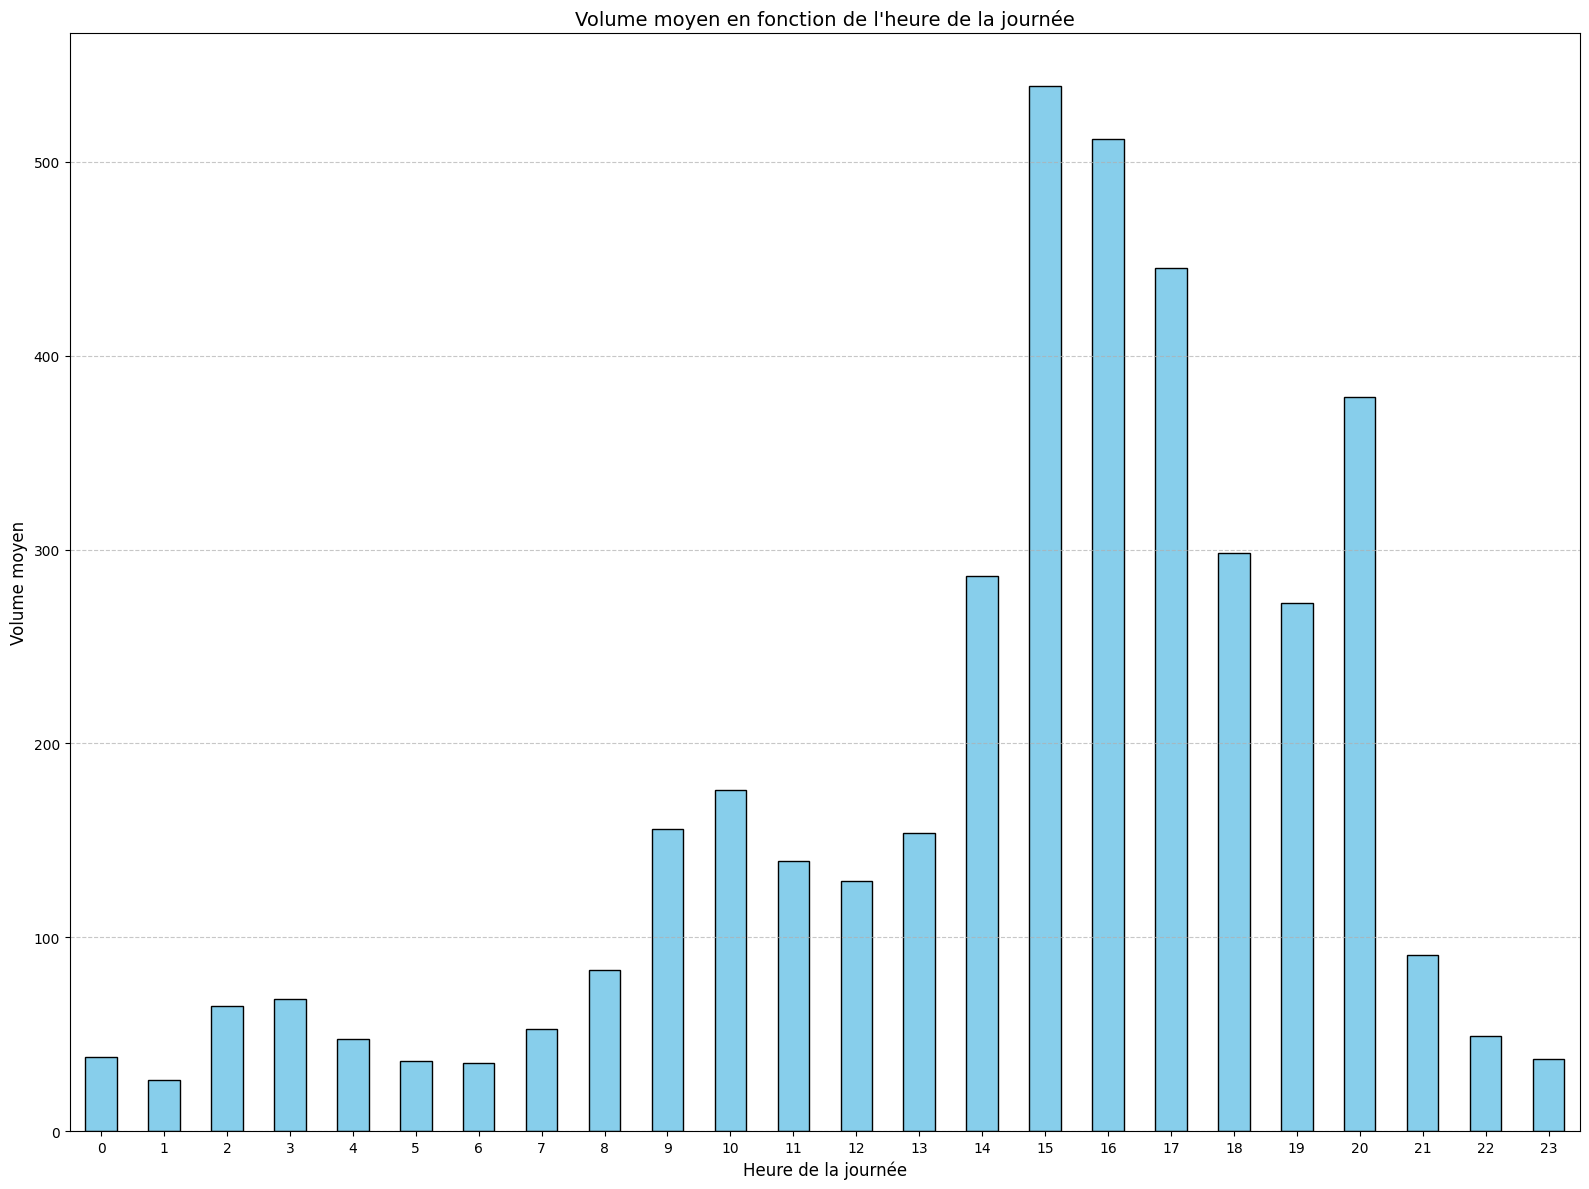

In [3]:

# Extraire l'heure de la journée à partir de 'timestamp'
df_main['hour'] = df_main['datetime'].dt.hour

# Calculer le volume moyen pour chaque heure
volume_moyen_par_heure = df_main.groupby('hour')['volume'].mean()

# Affichage des résultats sous forme d'histogramme
plt.figure(figsize=(16, 12))
volume_moyen_par_heure.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Volume moyen en fonction de l\'heure de la journée', fontsize=14)
plt.xlabel('Heure de la journée', fontsize=12)
plt.ylabel('Volume moyen', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Afficher l'histogramme
plt.tight_layout()
plt.show()

In [1]:
from processing_functions import return_trade_datas_dataframe
name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5']]_stopMethod=[1, 2]_TP=Variable_tickCrossed=[0, 2]_withCrossKijunExit=[True, False].pkl"
tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross
4,38.390,-31.80,-35.83,0.582,-0.398,2.13,"(539, 865, 14)",18.8,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,1,False,[5],0,True
68,37.245,-28.58,-32.64,0.595,-0.387,2.23,"(530, 893, 7)",17.9,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,2,False,[5],0,True
100,39.802,-24.68,-28.12,0.600,-0.434,1.95,"(482, 729, 2)",20.5,30,"(20, 40)",0 days 00:35:00,0 days 01:00:00,2,False,[5],2,True
36,40.852,-24.15,-27.58,0.592,-0.441,1.88,"(489, 708, 10)",21.3,30,"(20, 40)",0 days 00:35:00,0 days 01:05:00,1,False,[5],2,True
3,37.817,-24.27,-26.54,0.599,-0.411,2.02,"(298, 490, 9)",19.8,30,"(20, 40)",0 days 00:30:00,0 days 01:00:00,1,False,"[5, 15, 60]",0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,49.299,53.15,51.93,1.012,-0.745,1.65,"(211, 217, 0)",39.3,30,"(30, 70)",0 days 01:20:00,0 days 02:45:00,2,False,"[5, 15, 60]",2,False
32,47.543,57.92,55.61,0.968,-0.746,1.72,"(387, 427, 1)",37.8,30,"(30, 70)",0 days 01:25:00,0 days 02:50:00,1,False,[5],0,False
96,47.543,57.92,55.61,0.968,-0.746,1.72,"(387, 427, 1)",37.8,30,"(30, 70)",0 days 01:25:00,0 days 02:50:00,2,False,[5],0,False
31,50.522,64.28,62.91,0.990,-0.743,1.68,"(242, 237, 1)",38.7,30,"(30, 70)",0 days 01:30:00,0 days 02:50:00,1,False,"[5, 15, 60]",0,False


In [6]:
from processing_functions import describe_daily_and_weekly_trade_datas
describe_daily_and_weekly_trade_datas(name, selected_Id=7)

      profit_including_fees_from_start(%)
                                      sum
count                          690.000000
mean                             0.103161
std                              0.753343
min                             -2.514200
25%                             -0.258520
50%                              0.000000
75%                              0.244320
max                              3.241480 
       profit_including_fees_from_start(%)
                                      sum
count                           99.000000
mean                             0.718998
std                              1.893870
min                             -3.275560
25%                             -0.525280
50%                              0.721600
75%                              1.845180
max                              4.718760


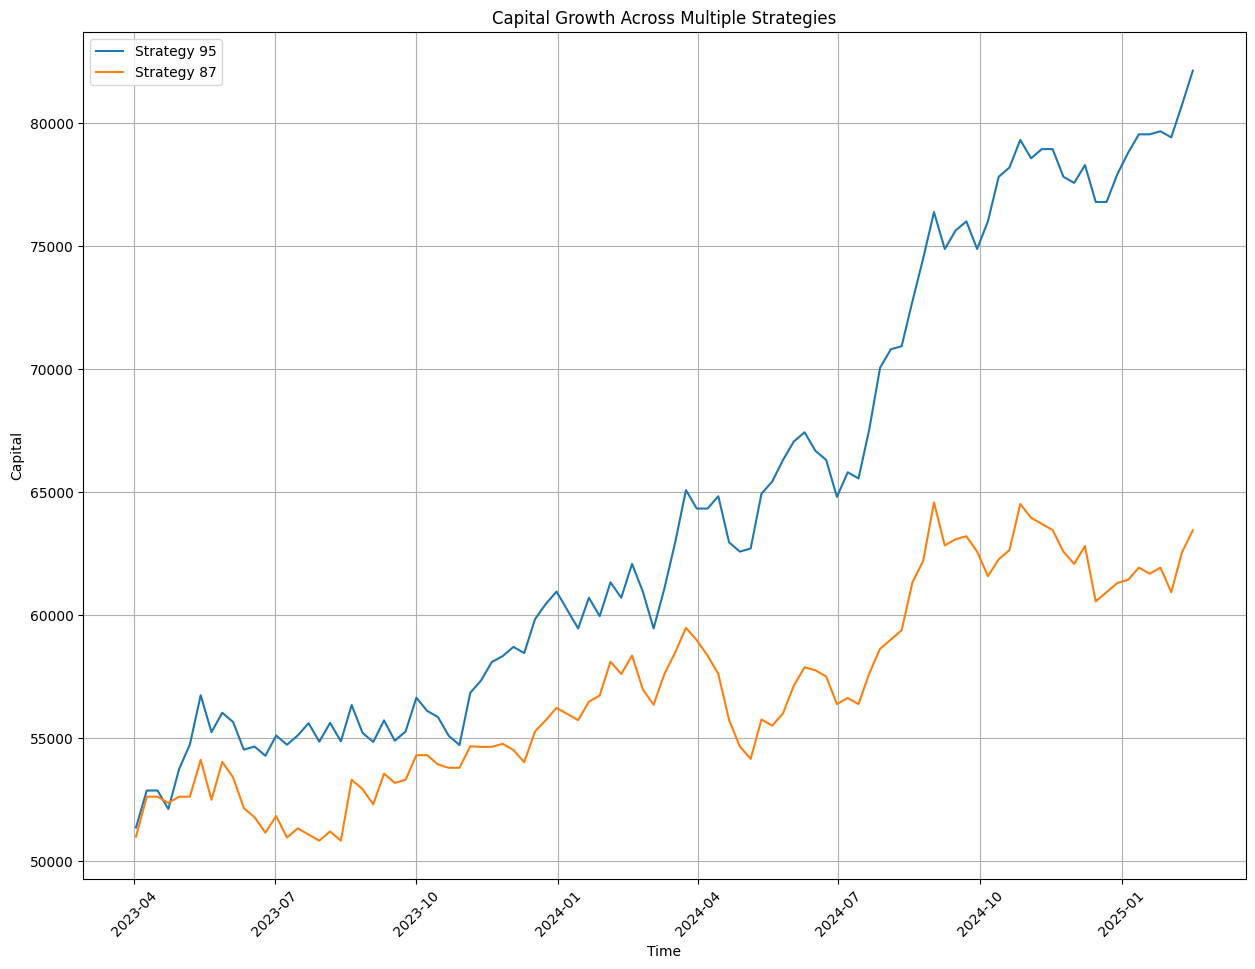

In [3]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name,
                             plotAllDatas=False, dataIdsSelected=[95, 87],
                             plotSize=(15,11))

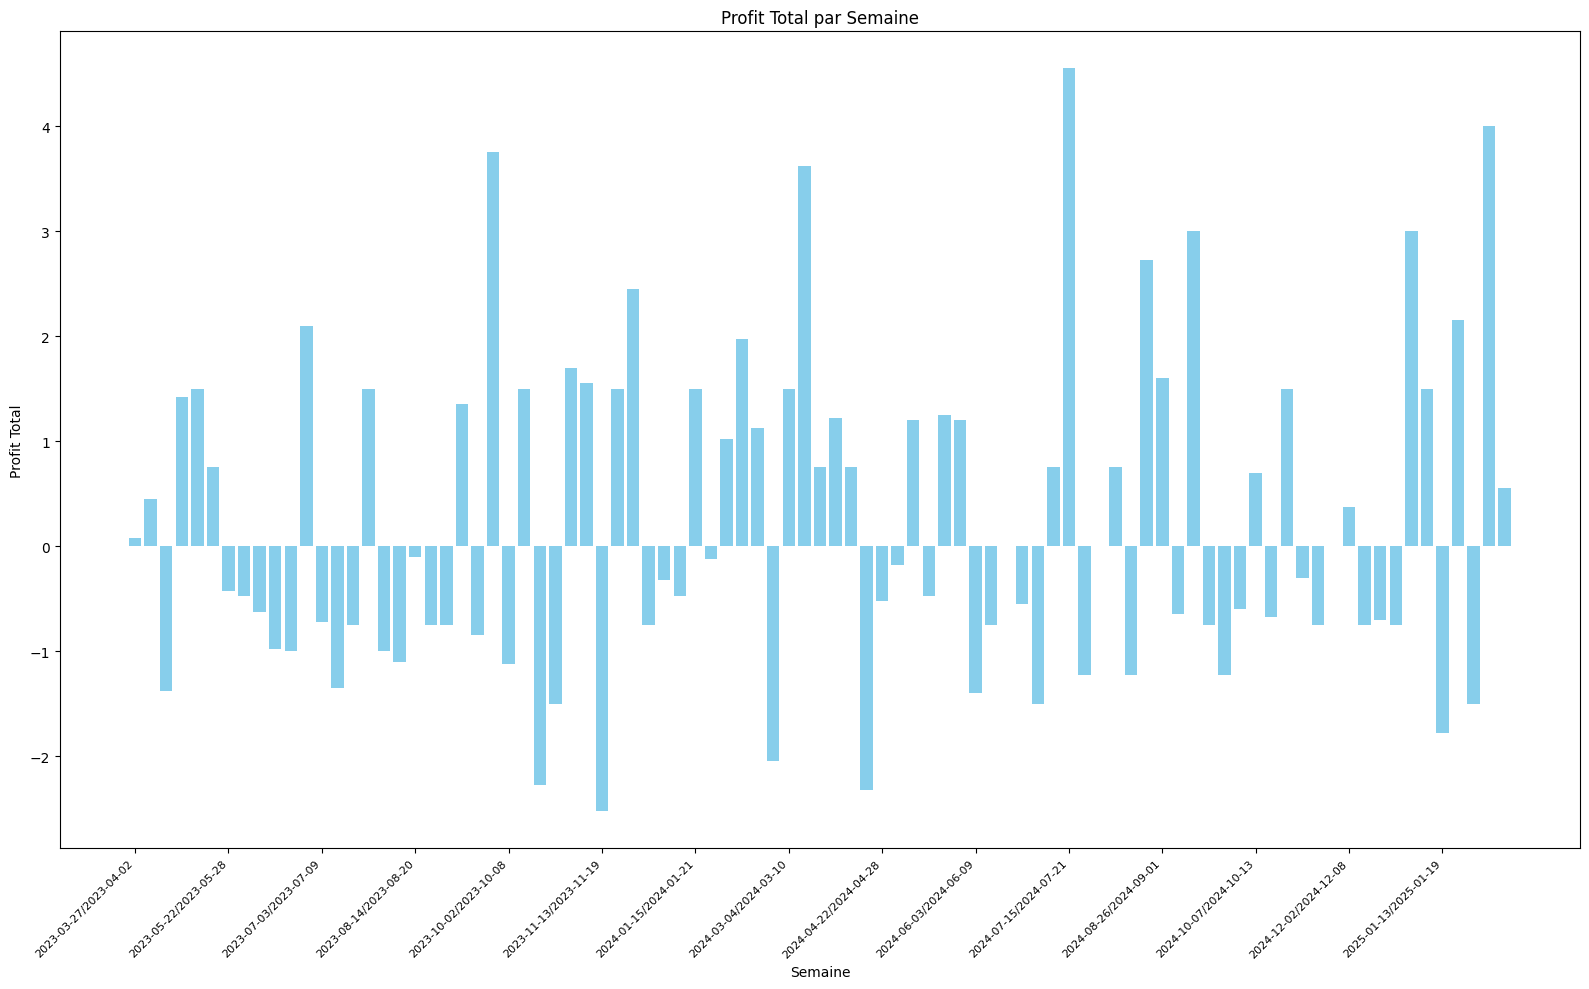

In [2]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name)

### TEST 2 : Utiliser les niveaux de prix généré avec les swings points ###

In [2]:
from processing_functions import return_trade_datas_dataframe
name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5']]_"\
    "stopMethod=[1, 2]_TP=Variable_tickCrossed=[0, 2]_withCrossKijunExit=[False]_windowForLevels=[6, 12]_"\
    "nbr_of_points=[2, 3]_delta_in_ticks=[5].pkl"
tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL [Ticks],TP [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross,nbr_of_points,delta_in_ticks,windowForLevels
66,39.655,4.75,4.59,1.321,-0.737,1.76,"(23, 35, 0)",39.9,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,1,True,[5],2,False,6,3,5
90,39.655,4.75,4.59,1.321,-0.737,1.76,"(23, 35, 0)",39.9,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,2,True,[5],2,False,6,3,5
70,40.816,5.25,5.11,1.320,-0.734,1.82,"(20, 29, 0)",41.3,30,"(30, 90)",0 days 01:10:00,0 days 02:45:00,1,True,[5],2,False,6,3,5
94,40.816,5.25,5.11,1.320,-0.734,1.82,"(20, 29, 0)",41.3,30,"(30, 90)",0 days 01:10:00,0 days 02:45:00,2,True,[5],2,False,6,3,5
54,42.424,7.75,7.56,1.272,-0.738,1.77,"(28, 38, 0)",39.7,30,"(30, 80)",0 days 00:55:00,0 days 02:35:00,1,True,[5],0,False,6,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,48.684,55.38,54.51,1.142,-0.734,1.85,"(148, 156, 0)",40.6,30,"(30, 90)",0 days 01:00:00,0 days 02:16:15,2,False,[5],0,False,12,2,5
104,48.773,56.82,55.90,1.126,-0.738,1.73,"(159, 167, 0)",40.4,30,"(30, 80)",0 days 00:55:00,0 days 02:15:00,1,False,[5],0,False,12,2,5
128,48.773,56.82,55.90,1.126,-0.738,1.73,"(159, 167, 0)",40.4,30,"(30, 80)",0 days 00:55:00,0 days 02:15:00,2,False,[5],0,False,12,2,5
100,49.704,62.18,61.22,1.113,-0.740,1.61,"(168, 170, 0)",40.3,30,"(30, 70)",0 days 00:55:00,0 days 01:58:45,1,False,[5],0,False,12,2,5


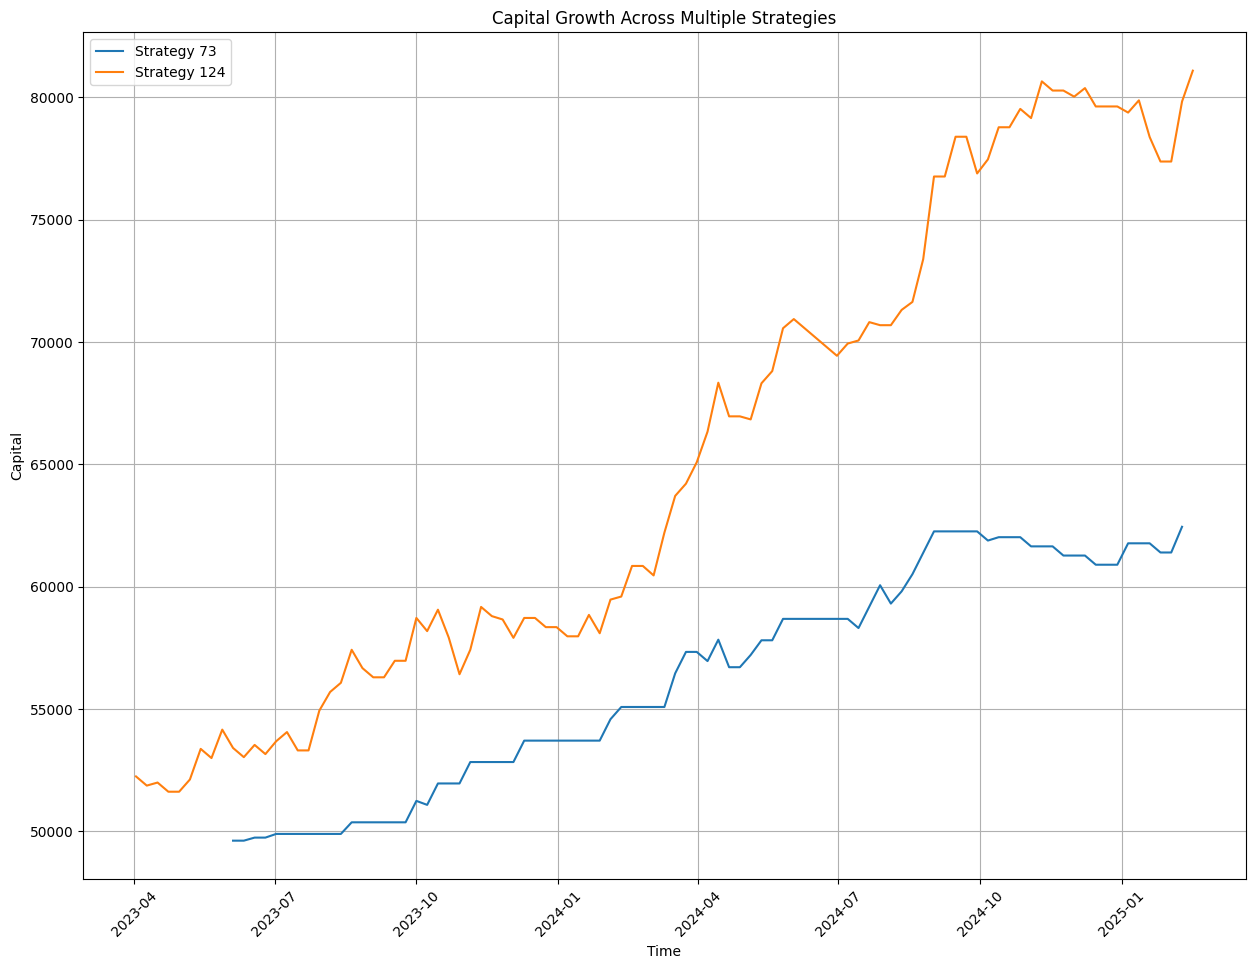

In [4]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name,
                             plotAllDatas=False, dataIdsSelected=[73,124],
                             plotSize=(15,11))

In [3]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(name)

winrate short: 0.34285714285714286, winrate long: 0.40625


### TEST 3 : Utiliser le chop index pour prendre position ###

In [2]:
from processing_functions import return_trade_datas_dataframe
name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False]chopValueToCross=[70, 61.8, 57, 50].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v1, sort_option=2)


ValueError: not enough values to unpack (expected 10, got 9)

In [ ]:
from processing_functions import return_trade_datas_dataframe

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False]chopValueToCross=[61.8]_chopPeriod=[14, 28, 48].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v2, sort_option=2)
tradeDatasFormated.tail(20)

ValueError: too many values to unpack (expected 8)

### TEST 4 : utiliser la sortie par cassure de kijun seulement si on est en profit ###

In [7]:
from processing_functions import return_trade_datas_dataframe
name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[['5', '15', '60'], ['5', '60'], ['5', '15'], ['5']]_"\
    "stopMethod=[2, 3]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False, True].pkl"

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 15], [5, 15, 60], [5, 60], [5, 15], [5]]_"\
    "stopMethod=[2, 3]_TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False, True].pkl"

name_v3 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [5, 5]]_stopMethod=[1, 2, 3, 4]_"\
    "TP=Variable_tickCrossed=[0]_withCrossKijunExit=[False, True].pkl"


tradeDatasFormated = return_trade_datas_dataframe(name_v3, sort_option=2)
tradeDatasFormated.iloc[-40:]

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stopMethodsForKijunExitExit,US_session_only,timeframes,ticksCrossed,tenkanCond
72,55.673,58.55,55.87,0.706,-0.753,0.87,"(525, 418, 0)",38.4,"(30, 30, 70)",0 days 01:20:00,0 days 02:15:00,3,False,"[5, 5]",0,True
48,52.370,59.80,57.22,0.804,-0.749,1.00,"(475, 432, 1)",38.1,"(30, 30, 70)",0 days 01:25:00,0 days 02:35:00,2,False,"[5, 5]",0,True
65,54.924,60.65,58.60,0.561,-0.503,0.95,"(396, 325, 0)",24.4,"(20, 30, 70)",0 days 00:24:00,0 days 00:38:00,3,True,[1],0,True
85,47.805,61.90,59.51,0.478,-0.303,1.21,"(403, 440, 0)",16.1,"(12, 30, 70)",0 days 00:12:00,0 days 00:21:00,4,True,[1],0,True
17,51.234,63.40,61.44,0.653,-0.503,1.11,"(353, 336, 0)",24.5,"(20, 30, 70)",0 days 00:26:00,0 days 00:43:00,1,True,[1],0,True
43,56.473,71.60,62.52,0.422,-0.503,0.78,"(1806, 1392, 0)",23.7,"(20, 30, 70)",0 days 00:35:00,0 days 00:58:00,2,False,[1],0,True
37,39.203,65.25,63.04,0.676,-0.303,1.72,"(305, 473, 0)",16.2,"(12, 30, 70)",0 days 00:16:00,0 days 00:35:00,2,True,[1],0,True
96,59.855,65.97,63.24,0.615,-0.753,0.75,"(577, 387, 0)",38.6,"(30, 30, 70)",0 days 01:10:00,0 days 01:55:00,4,False,"[5, 5]",0,True
68,47.519,67.03,64.05,0.684,-0.503,1.19,"(498, 550, 0)",27.3,"(20, 30, 70)",0 days 01:00:00,0 days 01:56:15,3,False,"[5, 5]",0,True
20,44.966,67.75,64.84,0.755,-0.502,1.31,"(460, 563, 0)",27.4,"(20, 30, 70)",0 days 01:00:00,0 days 02:10:00,1,False,"[5, 5]",0,True


In [5]:
from processing_functions import return_trade_datas_dataframe

name_v4 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [5]]_"\
    "stopMethod=[1, 2, 3, 4]_TP=Variable_tickCrossed=[0]_withCrossKijunExit=[False]_methodTenkanAngle=[2, 1].pkl"

name_v5 ="backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [5]]_"\
    "stopMethodsForKijunExitExit=[0, 2, 3, 4]_TP=Variable_tickCrossed=[0]_methodTenkanAngle=[2, 1].pkl"

name_v6 ="backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [5]]_"\
    "stopMethodsForKijunExitExit=[0, 2, 3, 4, 5]_TP=Variable_tickCrossed=[0]_methodTenkanAngle=[2]_forbiddenHours=[[7, 8, 11, 12]].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v6, sort_option=2)
tradeDatasFormated.iloc[-20:]

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stopMethodsForKijunExitExit,US_session_only,timeframes,ticksCrossed,tenkanCond
25,43.277,109.98,102.05,0.481,-0.303,1.35,"(1207, 1582, 0)",15.6,"(12, 30, 70)",0 days 00:20:00,0 days 00:38:00,2,False,[1],0,2
20,39.528,110.10,102.64,0.486,-0.253,1.58,"(1038, 1588, 0)",13.5,"(10, 30, 70)",0 days 00:17:00,0 days 00:34:00,2,False,"[1, 5]",0,2
43,46.875,111.52,103.25,0.419,-0.303,1.17,"(1365, 1547, 0)",15.6,"(12, 30, 70)",0 days 00:19:00,0 days 00:33:00,3,False,[1],0,2
23,40.503,111.50,103.59,0.463,-0.253,1.55,"(1128, 1657, 0)",13.3,"(10, 25, 70)",0 days 00:16:00,0 days 00:33:00,2,False,"[1, 5]",0,2
40,43.860,114.57,105.35,0.398,-0.253,1.33,"(1425, 1824, 0)",13.3,"(10, 25, 70)",0 days 00:15:00,0 days 00:29:00,3,False,[1],0,2
60,41.293,108.18,105.45,0.626,-0.253,1.68,"(396, 563, 0)",17.8,"(10, 25, 70)",0 days 00:25:00,0 days 00:55:00,4,False,[5],0,2
9,32.591,107.98,105.55,1.005,-0.302,2.42,"(278, 575, 0)",19.5,"(12, 30, 70)",0 days 00:30:00,0 days 01:15:00,0,False,[5],0,2
57,39.623,109.00,106.44,0.683,-0.253,1.78,"(357, 544, 0)",17.9,"(10, 30, 70)",0 days 00:25:00,0 days 01:00:00,4,False,[5],0,2
42,38.140,109.40,106.68,0.702,-0.253,1.90,"(365, 592, 0)",17.7,"(10, 25, 70)",0 days 00:25:00,0 days 01:00:00,3,False,[5],0,2
75,38.870,110.32,107.76,0.705,-0.253,1.84,"(351, 552, 0)",17.8,"(10, 30, 70)",0 days 00:25:00,0 days 01:00:00,5,False,[5],0,2


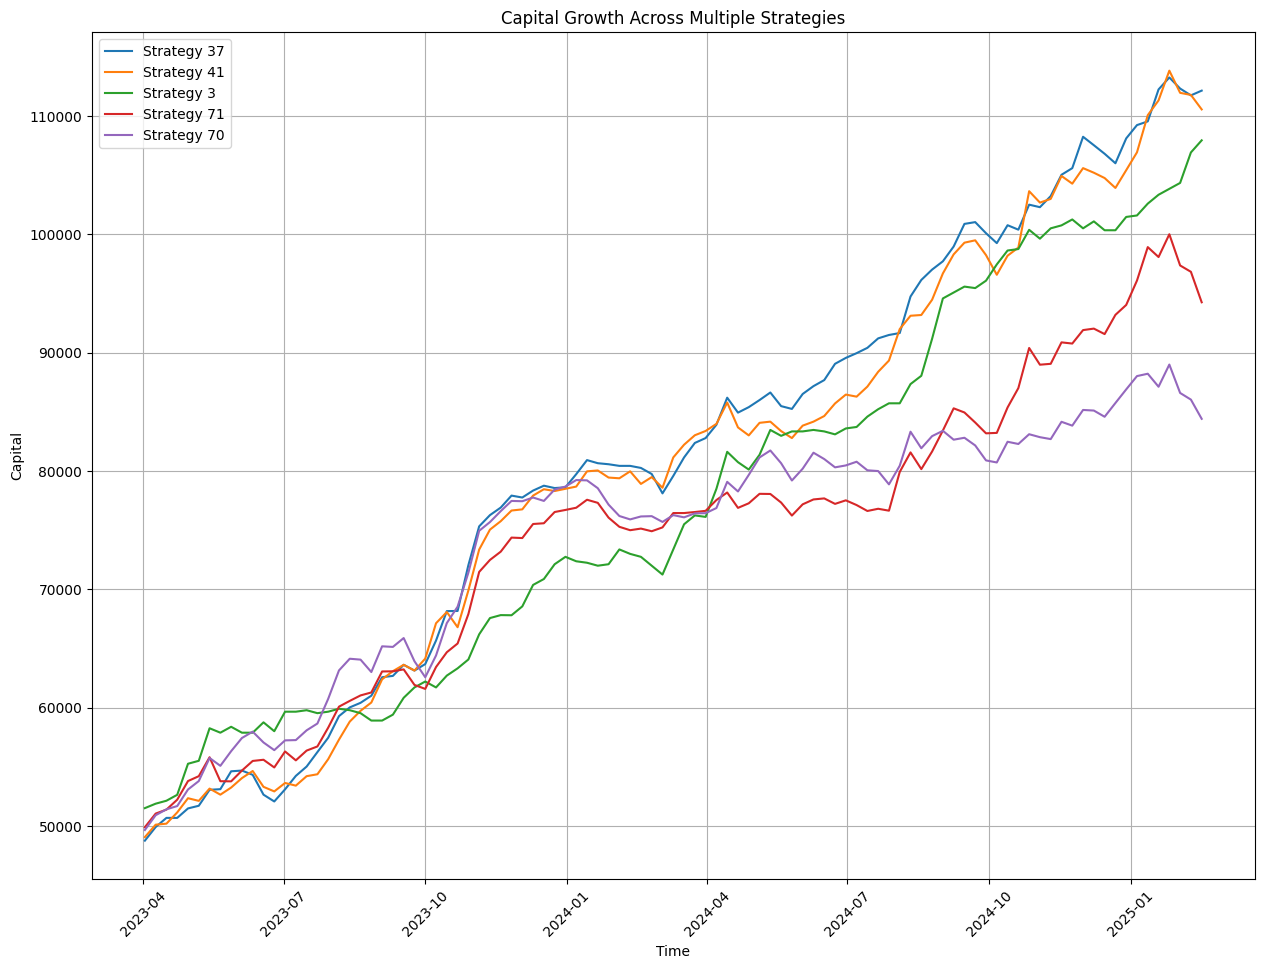

In [3]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name_v6,
                             plotAllDatas=False, dataIdsSelected=[37,41,3, 71, 70],
                             plotSize=(15,11))

In [2]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(name_v6, 37)

winrate short: 0.4123624047417443, winrate long: 0.44637223974763407


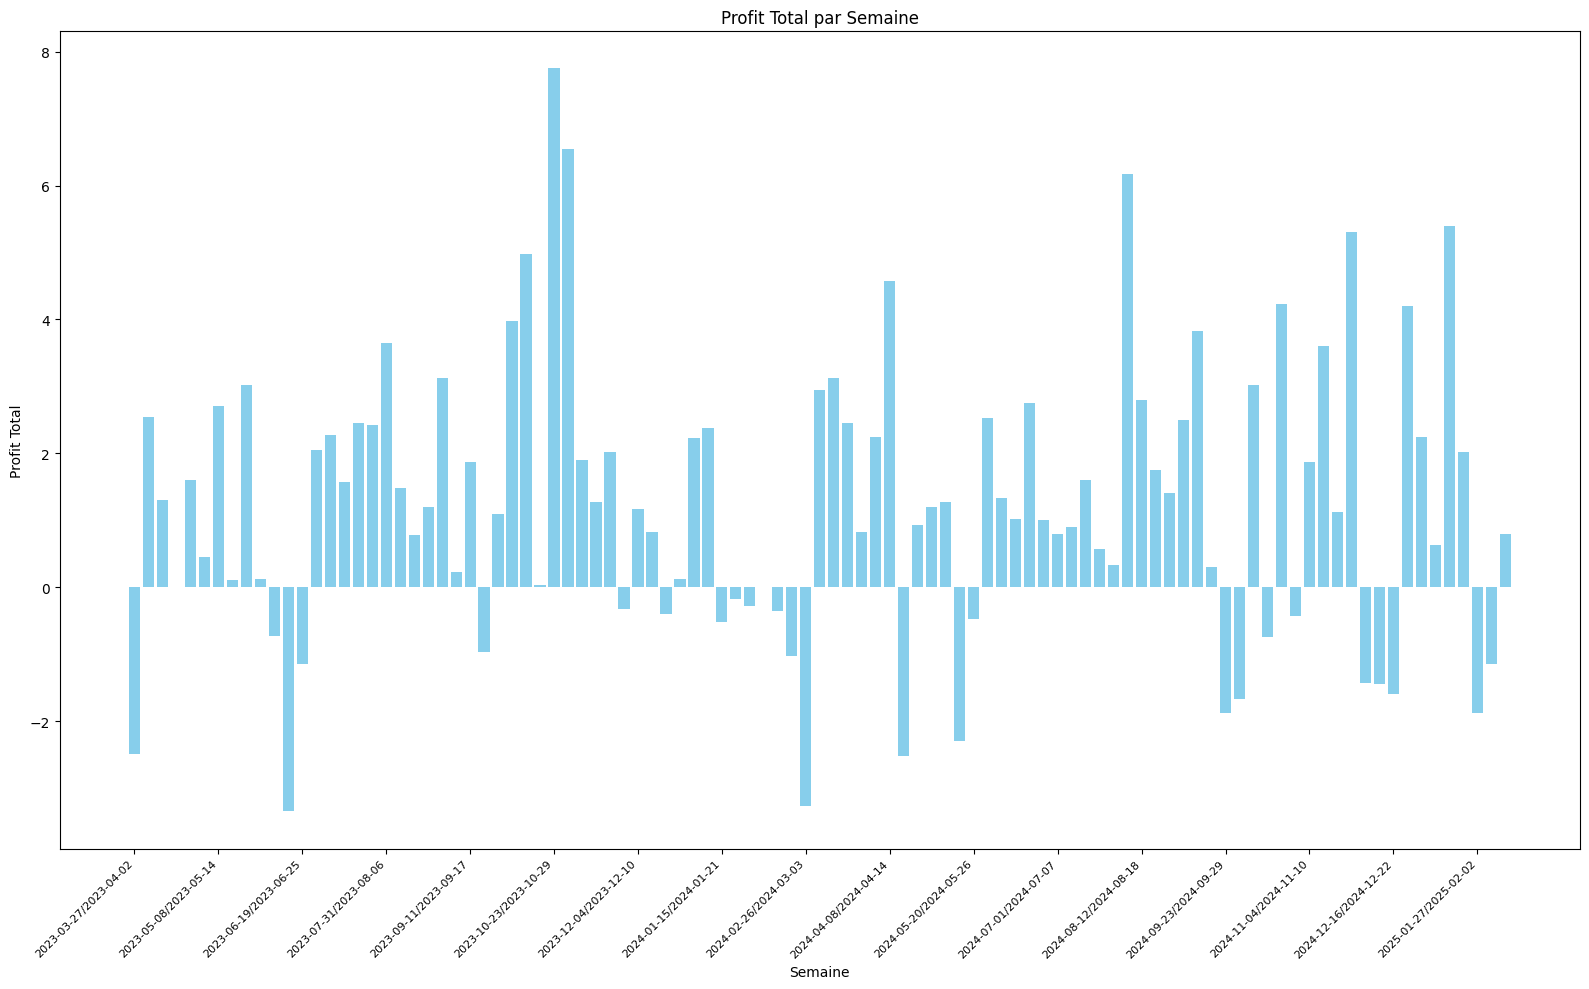

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name_v6,37)

In [1]:
from processing_functions import return_trade_datas_dataframe

name_v1 = "backtest_CL_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1, 5], [5]]_"\
    "stopMethodsForKijunExitExit=[0, 2, 3, 4]_TP=Variable_tickCrossed=[0]_methodTenkanAngle=[2].pkl"
name_v2 = "backtest_CL_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [5]]_"\
    "stopMethodsForKijunExitExit=[0, 2, 3, 4, 5]_TP=Variable_tickCrossed=[0]_methodTenkanAngle=[2]_forbiddenHours=[[7, 8, 11, 12]].pkl"
tradeDatasFormated = return_trade_datas_dataframe(name_v2, sort_option=2)
tradeDatasFormated.iloc[-20:]

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stopMethodsForKijunExitExit,US_session_only,timeframes,ticksCrossed,tenkanCond
24,31.500,47.82,44.77,0.573,-0.203,2.07,"(338, 735, 0)",0.7,"(10, 25, 70)",0 days 00:20:00,0 days 00:45:00,2,False,[5],0,2
5,26.955,52.98,45.17,0.610,-0.203,2.57,"(741, 2008, 0)",0.5,"(10, 25, 70)",0 days 00:12:00,0 days 00:30:00,0,False,"[1, 5]",0,2
27,32.618,48.28,45.50,0.643,-0.242,2.01,"(319, 659, 0)",0.8,"(12, 30, 70)",0 days 00:25:00,0 days 00:55:00,2,False,[5],0,2
29,40.964,54.84,46.83,0.390,-0.243,1.37,"(1156, 1666, 0)",0.6,"(12, 25, 70)",0 days 00:16:00,0 days 00:30:00,2,False,"[1, 5]",0,2
21,29.220,50.22,47.34,0.651,-0.203,2.30,"(296, 717, 0)",0.7,"(10, 30, 70)",0 days 00:20:00,0 days 00:50:00,2,False,[5],0,2
14,38.380,53.88,48.23,0.703,-0.398,1.65,"(763, 1225, 1)",0.9,"(20, 30, 70)",0 days 00:29:00,0 days 01:07:00,0,False,"[1, 5]",0,2
10,30.750,58.38,50.32,0.604,-0.243,2.13,"(873, 1966, 0)",0.6,"(12, 25, 70)",0 days 00:15:00,0 days 00:36:00,0,False,[1],0,2
37,40.262,60.72,51.17,0.339,-0.203,1.40,"(1354, 2009, 0)",0.5,"(10, 30, 70)",0 days 00:13:00,0 days 00:26:00,3,False,[1],0,2
43,44.575,60.96,52.03,0.339,-0.243,1.17,"(1401, 1742, 0)",0.6,"(12, 30, 70)",0 days 00:16:00,0 days 00:28:00,3,False,[1],0,2
20,36.376,60.40,52.19,0.404,-0.203,1.67,"(1052, 1840, 0)",0.5,"(10, 30, 70)",0 days 00:13:00,0 days 00:28:00,2,False,"[1, 5]",0,2


### TEST 5 : Vérifier les pattern de retournement/perte de momentum pour sortir de position ###

In [6]:
from processing_functions import return_trade_datas_dataframe


name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [5, 15, 60], [5, 15], [5]]_stopMethod=[3]_"\
    "TP=Variable_tickCrossed=[0, 1]_withCrossKijunExit=[False, True]_patternVerif=[True, False].pkl"


tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=1)
tradeDatasFormated #.tail(20)

ValueError: too many values to unpack (expected 8)

### TEST 6 : Utiliser le rsi pour entrer en position ###
TODO: a refaire avec la période du RSI variable

In [ ]:
from processing_functions import return_trade_datas_dataframe

name = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [5, 15, 60], [5, 15], [5]]_stopMethod=[3]_"\
    "TP=Variable_tickCrossed=[0]_withCrossKijunExit=[False, True]_rsiValues=[(50, 50), (55, 45), (60, 40), (65, 35)].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name, sort_option=2)
tradeDatasFormated #.tail(20)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross,rsiVal
189,65.707,-23.05,-27.29,0.365,-0.753,0.48,"(981, 512, 0)",34.1,"(30, 25, 60)",0 days 00:38:00,0 days 01:06:00,3,False,[1],0,True,"(60, 40)"
181,64.993,-20.43,-24.33,0.378,-0.753,0.49,"(893, 481, 0)",33.9,"(30, 30, 70)",0 days 00:39:00,0 days 01:06:00,3,False,[1],0,True,"(60, 40)"
253,65.572,-11.05,-13.38,0.370,-0.753,0.50,"(539, 283, 0)",33.4,"(30, 25, 60)",0 days 00:38:00,0 days 01:07:45,3,False,[1],0,True,"(65, 35)"
173,57.845,-4.80,-9.31,0.356,-0.503,0.67,"(918, 669, 0)",23.6,"(20, 25, 60)",0 days 00:30:00,0 days 00:52:00,3,False,[1],0,True,"(60, 40)"
245,65.138,-6.45,-8.62,0.386,-0.753,0.51,"(497, 266, 0)",33.5,"(30, 30, 70)",0 days 00:38:00,0 days 01:07:30,3,False,[1],0,True,"(65, 35)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,42.094,67.57,62.15,0.768,-0.502,1.45,"(804, 1106, 1)",23.7,"(20, 25, 60)",0 days 00:45:00,0 days 01:40:00,3,False,[1],0,False,"(55, 45)"
72,41.536,65.85,64.04,0.949,-0.501,1.67,"(265, 373, 1)",27.2,"(20, 30, 70)",0 days 01:00:00,0 days 02:15:00,3,False,[5],0,False,"(55, 45)"
71,42.327,65.85,64.16,0.940,-0.501,1.65,"(251, 342, 1)",27.0,"(20, 30, 70)",0 days 01:05:00,0 days 02:13:45,3,False,"[5, 15]",0,False,"(55, 45)"
8,40.278,72.58,70.32,0.965,-0.501,1.72,"(319, 473, 1)",26.8,"(20, 30, 70)",0 days 01:00:00,0 days 02:10:00,3,False,[5],0,False,"(50, 50)"


### TEST 7 : Ne pas entrer en position sur des bougies trop grandes ###


In [1]:
from processing_functions import return_trade_datas_dataframe


name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [5, 15, 60], [5, 15], [5]]_"\
    "stopMethod=[3]_TP=Variable_tickCrossed=[0]_withCrossKijunExit=[False, True]_withbigcandlecheck.pkl"

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [5, 15, 60], [5, 15], [5]]_"\
    "stopMethod=[3]_TP=Variable_tickCrossed=[0]_withCrossKijunExit=[False, True]_withbigcandlecheck2.pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v2, sort_option=2)
tradeDatasFormated .tail(10)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stop_method,US_session_only,timeframes,ticksCrossed,kijuncross
46,65.789,20.95,20.30,0.527,-0.753,0.65,"(150, 78, 0)",37.8,"(30, 30, 70)",0 days 01:55:00,0 days 02:50:00,3,False,"[5, 15, 60]",0,True
25,50.742,26.55,25.59,0.444,-0.303,1.18,"(171, 166, 0)",15.4,"(12, 30, 70)",0 days 00:19:00,0 days 00:33:00,3,True,[1],0,True
1,23.469,26.62,25.79,1.361,-0.303,3.63,"(69, 225, 0)",15.6,"(12, 30, 70)",0 days 00:24:00,0 days 01:28:00,3,True,[1],0,False
21,47.105,30.15,26.13,0.880,-0.748,1.16,"(667, 749, 1)",33.4,"(30, 30, 70)",0 days 01:39:00,0 days 02:54:00,3,False,[1],0,False
33,61.321,30.85,29.95,0.471,-0.503,0.79,"(195, 123, 0)",24.4,"(20, 30, 70)",0 days 00:27:00,0 days 00:43:45,3,True,[1],0,True
41,69.079,31.18,30.31,0.481,-0.753,0.58,"(210, 94, 0)",34.1,"(30, 30, 70)",0 days 00:35:00,0 days 00:52:00,3,True,[1],0,True
5,28.167,45.88,40.36,0.846,-0.303,2.52,"(547, 1395, 0)",14.9,"(12, 30, 70)",0 days 00:40:30,0 days 01:30:00,3,False,[1],0,False
9,35.206,41.95,41.19,1.358,-0.500,2.38,"(94, 173, 0)",23.7,"(20, 30, 70)",0 days 00:49:00,0 days 02:14:00,3,True,[1],0,False
13,39.337,62.95,58.41,0.867,-0.502,1.66,"(629, 970, 0)",23.3,"(20, 30, 70)",0 days 01:07:00,0 days 02:17:00,3,False,[1],0,False
17,47.154,60.20,59.50,1.336,-0.734,1.68,"(116, 130, 0)",33.2,"(30, 30, 70)",0 days 01:19:00,0 days 02:38:30,3,True,[1],0,False


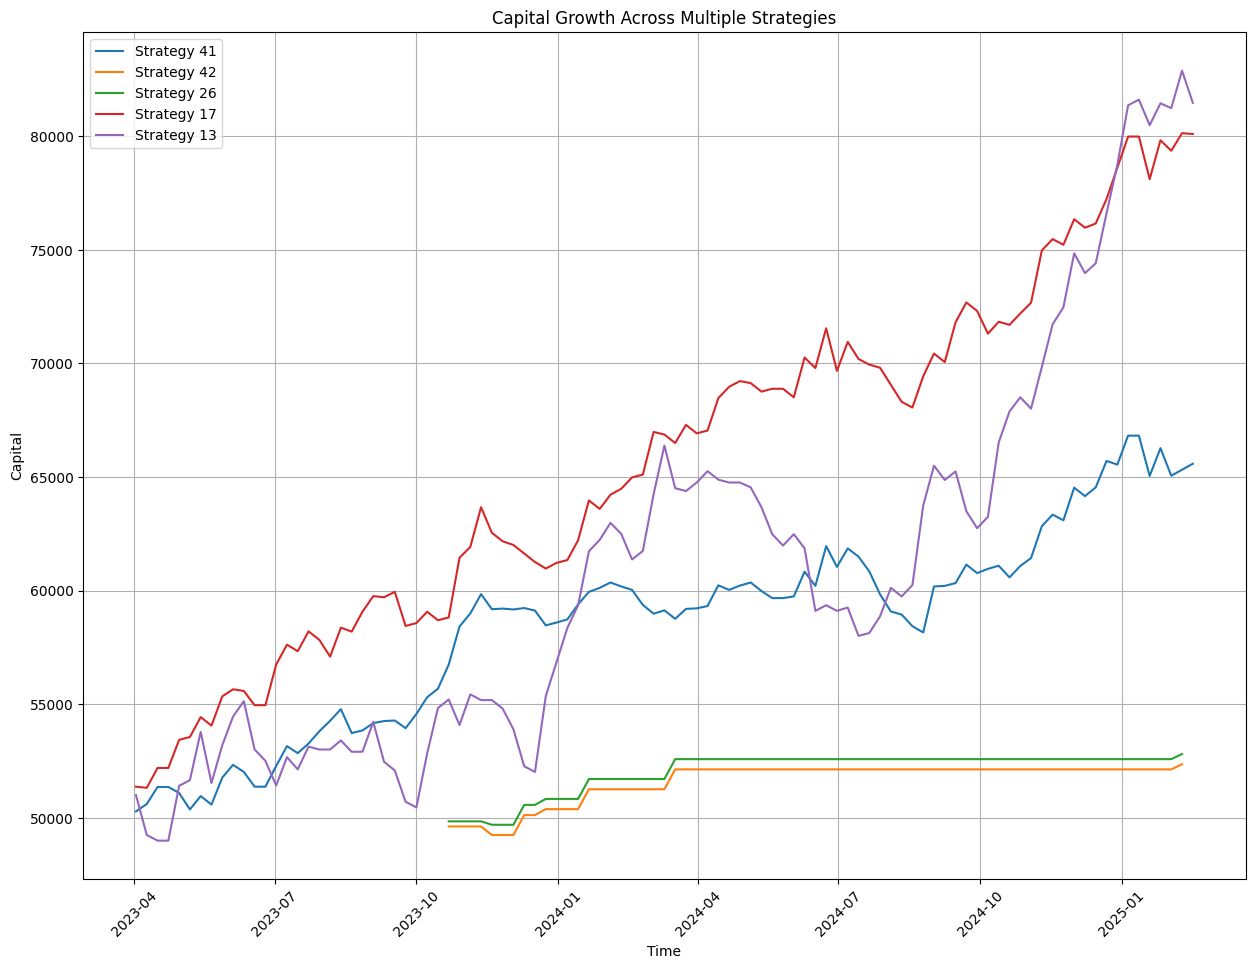

In [11]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name_v2,
                             plotAllDatas=False, dataIdsSelected=[41,42,26,17,13],
                             plotSize=(15,11))

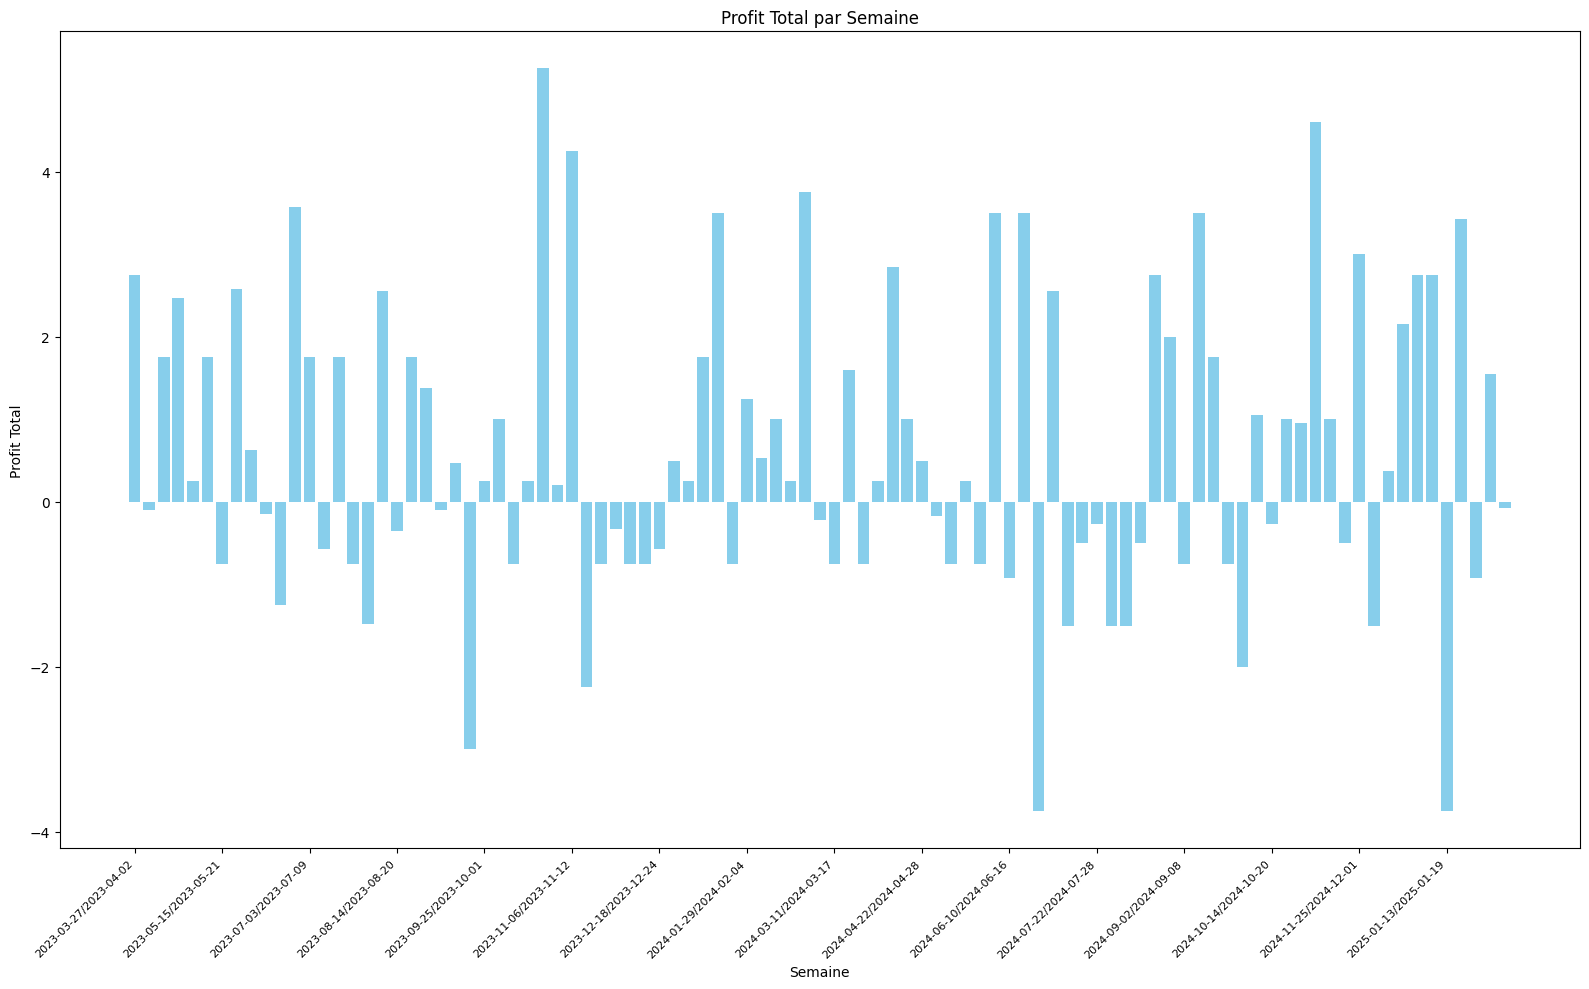

In [2]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name_v2, 17)

#### TEST 8 : utiliser les breakeven, déplacer le stop loss ###

In [27]:
from processing_functions import return_trade_datas_dataframe

name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [5]]_stopMethodsForKijunExitExit=[0, 2, 3, 4, 5]_"\
    "forbiddenHours=[[7, 8, 11, 12]]_slModifiers=[[0.75, 0.5], [0.5, 0.15], [0.75, 0.3]].pkl"

name_v2 ="backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [1, 5, 15], [5, 15]]_"\
    "stopMethodsForKijunExitExit=[0, 2, 3, 4, 5]_forbiddenHours=[[7, 8, 11, 12]]_slModifiers=[[0.6, 0.12], [0.5, 0.15], [0.4, 0.3]].pkl"

name_v3 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5], [1, 5, 15]]_"\
    "stopMethodsForKijunExitExit=[2, 3, 4]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[0.6, 0.12], [0.5, 0.15], [0.7, 0.2]].pkl"

name_v4 = "backtest_ES_from[2020-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3]_forbiddenHours=[[7, 8, 11, 12]]_slModifiers=[[0.5, 0.15]].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v3, sort_option=2)
tradeDatasFormated .tail(40)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed SL [Ticks],SL/TP1/TP2 [Ticks],Q2 duration (médiane),Q3 duration (75%),stopMethodsForKijunExitExit,US_session_only,timeframes,ticksCrossed,tenkanCond,slModifiers,forbbiden Hours
158,68.897,111.53,104.27,0.286,-0.503,0.57,"(1761, 795, 0)",23.7,"(20, 25, 70)",0 days 00:17:00,0 days 00:30:00,4,False,"[1, 5]",0,2,"[0.5, 0.15]","[7, 8, 11, 12]"
4,44.948,113.62,104.34,0.381,-0.253,1.35,"(1468, 1798, 0)",13.1,"(10, 25, 65)",0 days 00:15:00,0 days 00:31:45,2,False,[1],0,2,"[0.6, 0.12]","[7, 8, 11, 12]"
27,52.013,111.30,104.39,0.362,-0.303,1.07,"(1266, 1168, 0)",15.6,"(12, 25, 70)",0 days 00:17:00,0 days 00:31:00,3,False,"[1, 5, 15]",0,2,"[0.6, 0.12]","[7, 8, 11, 12]"
8,50.000,112.01,104.43,0.381,-0.303,1.17,"(1333, 1333, 0)",15.3,"(12, 25, 70)",0 days 00:18:00,0 days 00:35:00,2,False,"[1, 5]",0,2,"[0.6, 0.12]","[7, 8, 11, 12]"
111,48.831,111.64,104.48,0.350,-0.253,1.25,"(1232, 1291, 0)",13.3,"(10, 25, 70)",0 days 00:14:00,0 days 00:30:00,2,False,"[1, 5, 15]",0,2,"[0.5, 0.15]","[7, 8, 11, 12]"
112,47.970,114.12,104.68,0.340,-0.253,1.24,"(1595, 1730, 0)",13.0,"(10, 25, 65)",0 days 00:14:00,0 days 00:30:00,2,False,[1],0,2,"[0.5, 0.15]","[7, 8, 11, 12]"
24,47.650,112.29,104.80,0.361,-0.253,1.25,"(1257, 1381, 0)",13.4,"(10, 25, 65)",0 days 00:14:00,0 days 00:29:00,3,False,"[1, 5, 15]",0,2,"[0.6, 0.12]","[7, 8, 11, 12]"
239,46.586,113.33,104.84,0.365,-0.253,1.29,"(1392, 1596, 0)",13.2,"(10, 25, 65)",0 days 00:15:00,0 days 00:29:00,3,False,"[1, 5]",0,2,"[0.7, 0.2]","[7, 8, 11, 12]"
38,52.197,113.64,105.04,0.298,-0.253,1.04,"(1580, 1447, 0)",13.1,"(10, 25, 70)",0 days 00:12:00,0 days 00:20:30,4,False,"[1, 5]",0,2,"[0.6, 0.12]","[7, 8, 11, 12]"
117,53.386,112.02,105.23,0.347,-0.303,1.08,"(1277, 1115, 0)",15.4,"(12, 25, 70)",0 days 00:16:00,0 days 00:33:00,2,False,"[1, 5, 15]",0,2,"[0.5, 0.15]","[7, 8, 11, 12]"


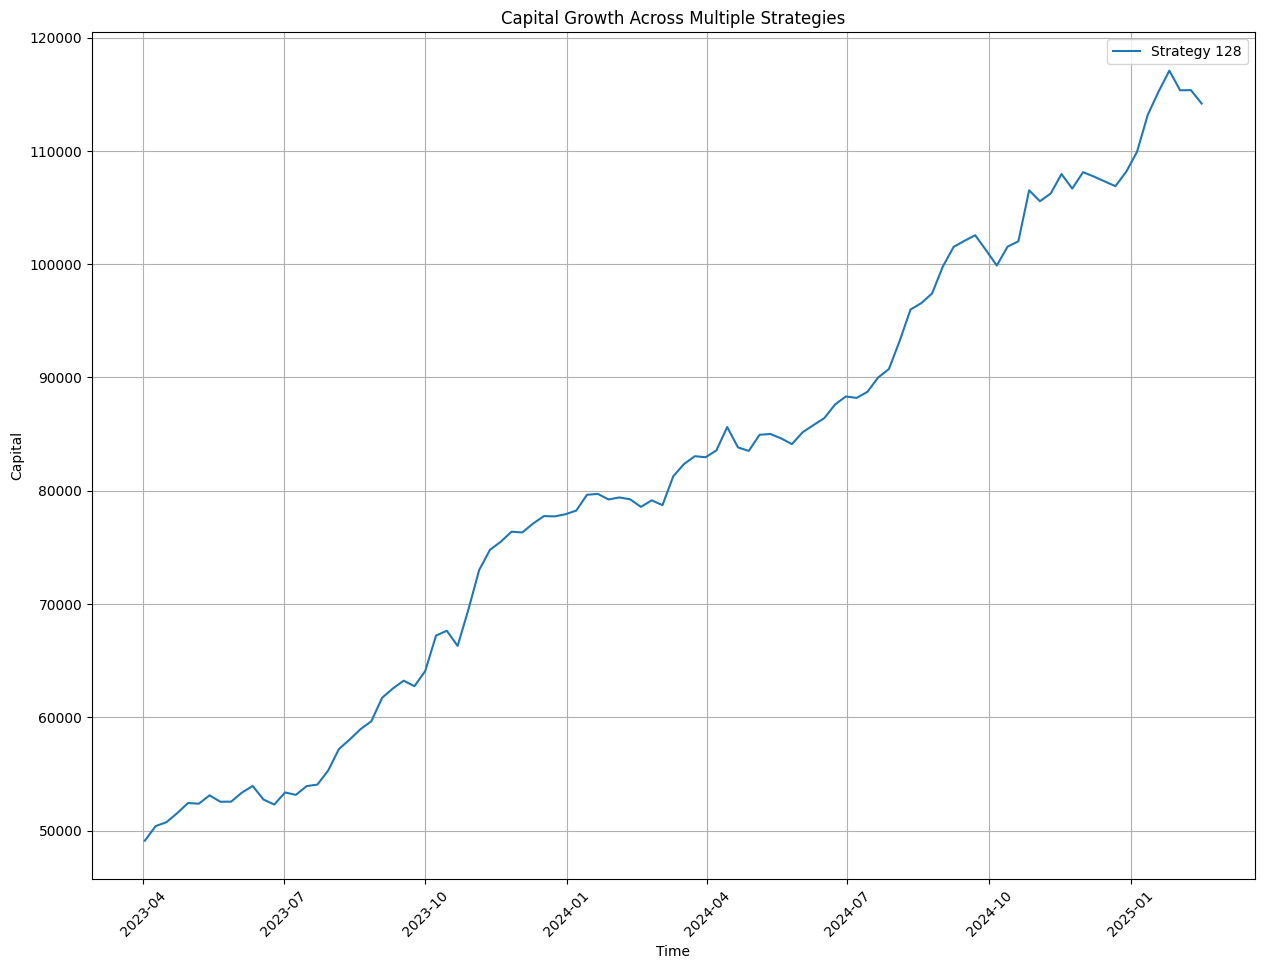

In [28]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+name_v3,
                             plotAllDatas=False, dataIdsSelected=[128],
                             plotSize=(15,11))

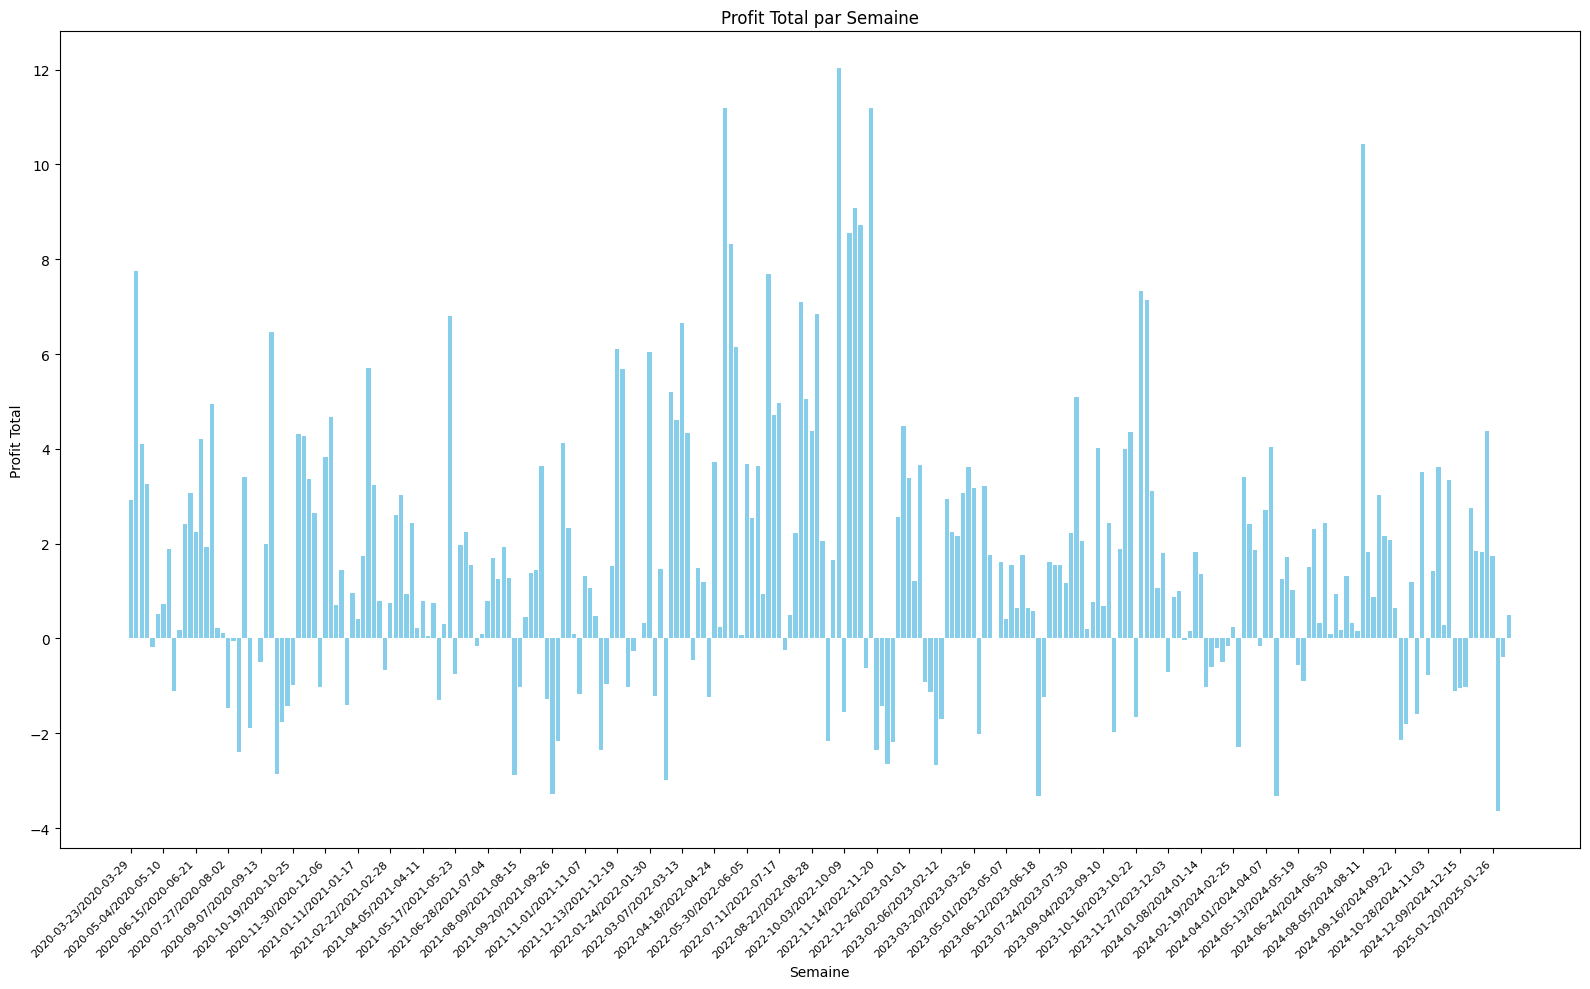

In [3]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name_v4, 1)

### TEST 9 : utiliser la SSB en haute timeframe comme niveau supplémentaire ###

In [2]:
from processing_functions import return_trade_datas_dataframe

name_v1 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1, 15], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[0.5, 0.15]]_withssbCheck.pkl"

name_v2 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1, 15], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[0.5, 0.15], []]_FlatSSBCheck.pkl"

name_v3 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1, 15], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[0.5, 0.15], []]_withSSBCheck2.pkl"

name_v4 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[0.5, 0.15], []]_withTenkanCond.pkl"

name_v5 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[([0.5, 0.15], [0.764, 0.3])].pkl"

name_v6 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[([0.5, 0.05], [0.764, 0.3])].pkl"

name_v7 = "backtest_ES_from[2023-03-24 12-00]_to[2025-02-14 12-00]_posSize=1_timeframe=[[1], [1, 5]]_"\
    "stopMethodsForKijunExitExit=[3, 2]_forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[([0.5, 0.05], [0.764, 0.3])]_at.pkl"

name_v8 = "ES/[2023-03-24 12-00]_[2025-02-14 12-00]/size=1_timeframe=[[1], [1, 5], [5]]_KijunExitMethod=[3, 4]_"\
    "forbiddenHours=[[7, 8, 11, 12], []]_slModifiers=[[], [[0.5, 0.15]], [[0.5, 0.0], [0.764, 0.3]]]_atrRatio=[[1.2, 1.2], [1.5, 1.2], [1.5, 1.5], [1.8, 1.3], [2, 1.4]].pkl"

tradeDatasFormated = return_trade_datas_dataframe(name_v8, sort_option=2)
tradeDatasFormated

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,forbbiden Hours,atrRatio,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
82,50.091,-32.14,-57.00,0.175,-0.189,0.96,"(4386, 4370, 0)",9.5,9.9,0 days 00:06:00,0 days 00:11:00,[1],[],[],"[1.5, 1.5]",4,False,0
10,49.074,-26.87,-54.62,0.146,-0.152,1.01,"(4795, 4976, 0)",8.3,8.3,0 days 00:04:00,0 days 00:08:00,[1],[],[],"[1.2, 1.2]",4,False,0
7,48.342,-23.99,-51.58,0.151,-0.152,1.04,"(4695, 5017, 0)",8.6,8.3,0 days 00:04:00,0 days 00:08:00,[1],[],[],"[1.2, 1.2]",3,False,0
79,48.587,-25.39,-49.91,0.188,-0.189,1.03,"(4196, 4440, 0)",10.2,9.8,0 days 00:06:00,0 days 00:11:00,[1],[],[],"[1.5, 1.5]",3,False,0
83,50.176,-27.71,-49.45,0.176,-0.190,0.97,"(3840, 3813, 0)",9.6,9.9,0 days 00:06:00,0 days 00:11:00,"[1, 5]",[],[],"[1.5, 1.5]",4,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,62.171,187.38,160.40,0.133,-0.173,0.74,"(5905, 3593, 0)",6.7,9.0,0 days 00:05:00,0 days 00:09:00,[1],"[[0.5, 0.15]]",[],"[2, 1.4]",3,False,0
58,66.141,194.55,164.46,0.100,-0.149,0.69,"(7007, 3587, 0)",5.5,8.0,0 days 00:04:00,0 days 00:06:00,[1],"[[0.5, 0.15]]",[],"[1.5, 1.2]",4,False,0
55,66.116,196.33,166.24,0.100,-0.149,0.70,"(7005, 3590, 0)",5.6,8.0,0 days 00:04:00,0 days 00:06:00,[1],"[[0.5, 0.15]]",[],"[1.5, 1.2]",3,False,0
130,63.533,195.34,167.06,0.119,-0.161,0.73,"(6326, 3631, 0)",6.2,8.5,0 days 00:04:00,0 days 00:08:00,[1],"[[0.5, 0.15]]",[],"[1.8, 1.3]",4,False,0


In [2]:
from processing_functions import return_trade_datas_dataframe

filename = "size=1_timeframe=[[15]]_KijunExitMethod=[3]_forbiddenHours=[[]]_slModifiers=[[]]_atrRatio=[[1.8, 1.3], [1.5, 1.5], [2, 1.4], [1.6, 1.3]]"
filepath = f"ES/[2023-03-24 12-00]_[2025-02-14 12-00]/{filename}_real.pkl"

tradeDatasFormated = return_trade_datas_dataframe(filepath, sort_option=2)
tradeDatasFormated.tail(15)

,Winrate [%],Total return brut [%],Total return net [%],Avg. gain net [%],Avg. loss net [%],Risk ratio,Nbr Wins/Loss/Breakeven,Avg. executed TP [Ticks],Avg. executed SL [Ticks],Q2 duration (médiane),Q3 duration (75%),timeframes,slModifiers,forbbiden Hours,atrRatio,stopMethodsForKijunExitExit,US_session_only,ticksCrossed
6,48.039,-7.14,-7.43,0.955,-1.023,0.94,"(49, 53, 0)",38.3,40.8,0 days 01:00:00,0 days 01:45:00,[15],[],[],"[2, 1.4]",3,True,0
8,49.275,-2.80,-3.19,0.887,-0.907,0.98,"(68, 70, 0)",35.6,36.2,0 days 00:45:00,0 days 01:56:15,[15],[],[],"[1.6, 1.3]",3,True,0
2,49.580,-1.30,-1.64,0.914,-0.926,0.99,"(59, 60, 0)",36.7,36.9,0 days 00:45:00,0 days 01:30:00,[15],[],[],"[1.8, 1.3]",3,True,0
7,50.409,1.02,-1.07,0.536,-0.548,0.99,"(370, 364, 0)",21.5,21.8,0 days 00:30:00,0 days 01:00:00,[15],[],[],"[1.6, 1.3]",3,False,0
4,53.846,0.38,-0.03,0.899,-1.049,0.86,"(77, 66, 0)",36.1,41.9,0 days 00:45:00,0 days 02:00:00,[15],[],[],"[1.5, 1.5]",3,True,0
5,49.685,3.79,1.99,0.600,-0.586,1.03,"(315, 319, 0)",24.1,23.3,0 days 00:45:00,0 days 01:15:00,[15],[],[],"[2, 1.4]",3,False,0
1,48.684,3.96,2.02,0.574,-0.539,1.08,"(333, 351, 0)",23.1,21.4,0 days 00:30:00,0 days 01:00:00,[15],[],[],"[1.8, 1.3]",3,False,0
3,55.616,5.75,3.65,0.520,-0.641,0.82,"(411, 328, 0)",20.9,25.5,0 days 00:30:00,0 days 01:00:00,[15],[],[],"[1.5, 1.5]",3,False,0


In [4]:
from processing_functions import get_winrate_by_short_and_long_position
get_winrate_by_short_and_long_position(filepath, 3)

winrate short: 0.6455696202531646, winrate long: 0.5139442231075697


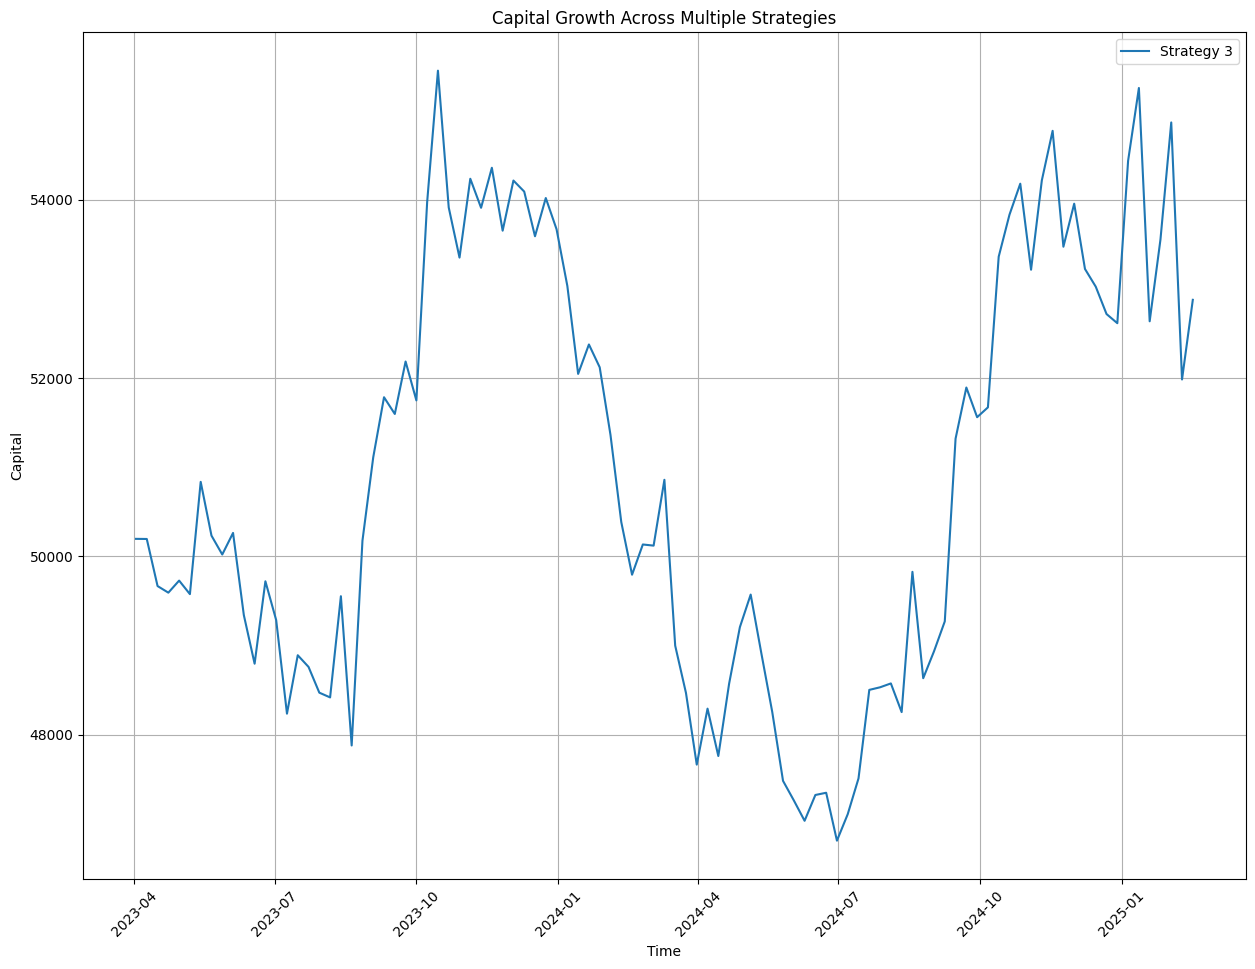

In [5]:
from processing_functions import plot_backtested_return_curve
plot_backtested_return_curve(pathOfData='trade_datas/'+filepath,
                             plotAllDatas=False, dataIdsSelected=[3],
                             plotSize=(15,11))

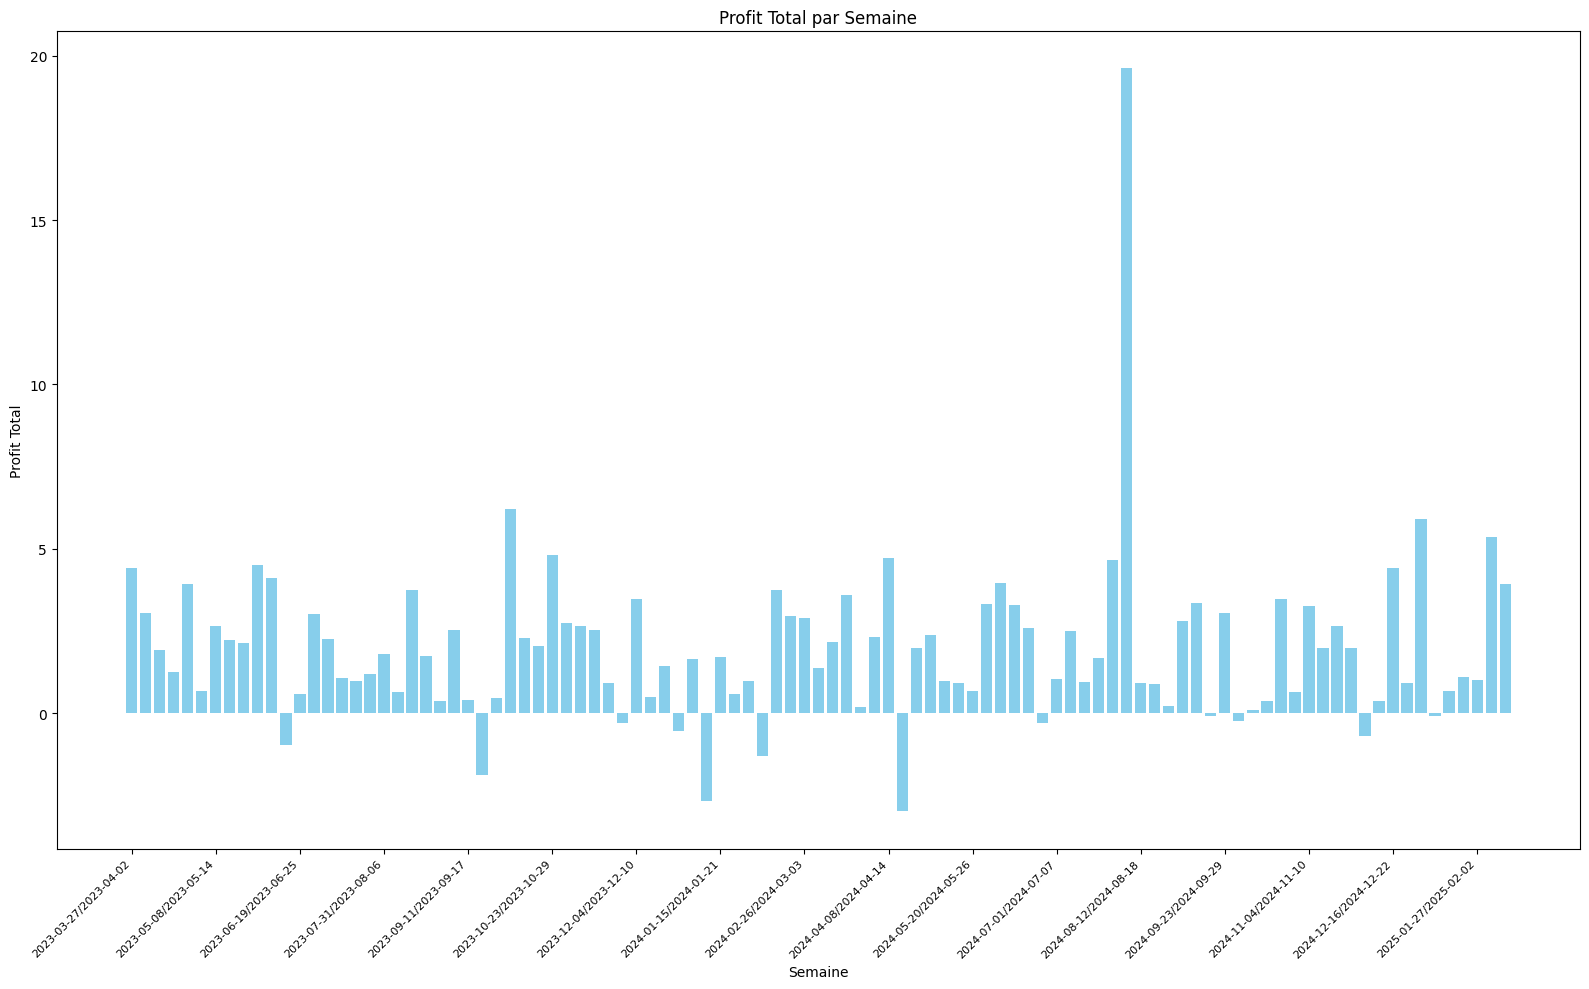

In [4]:
from processing_functions import plot_bars_of_profit_for_every_weeks
plot_bars_of_profit_for_every_weeks(name_v8, 127)

choses à faire pour continuer à backtest :
- avoir le temps moyen d'un trade avec la stratégie DTP : FAIT!
- regarder si le type de position (short ou long) a un impact sur le winrate
- continuer à améliorer la stratégie avec:
    - les autres conditions d'entrées de la strat DTP (ex: taille de la bougie)
    - des conditions sur les niveaux pivot
    - des conditions pour savoir si on est en range
    - faire en sorte que le tp/sl s'adapte à la distance au pivot
- calculer le profit réel en $ : FAIT!
- stop loss suiveur : passe en breakeven sous certaines conditions 
- condition sur l'entré en position avec le RSI : entrer seulement si dans la zone de hausse ou de baisse temperé 
- condition sur la taille de la bougie (bougie trop grande = news). On pourra utiliser les taille moyenne de bougie/H
- utilise l'API pour avoir l'historique des news